## EDA: World University Rankings 

Using the [World University Rankings] (https://www.topuniversities.com/university-rankings/world-university-rankings/2022) from 2017 to 2022, EDA (Exploratory Data Analysis) is performed to gain insight about the most popular universities in the world.

#### Information about the Data
QS World University Rankings is an annual publication of global university rankings by Quacquarelli Symonds. The QS ranking receives approval from the International Ranking Expert Group (IREG), and is viewed as one of the three most-widely read university rankings in the world. QS publishes its university rankings in partnership with Elsevier.

The dataset used is from [Kaggle] (https://www.kaggle.com/datasets/padhmam/qs-world-university-rankings-2017-2022). The original data was acquired by scraping the QS World University Rankings website with Python and Selenium.

#### Ranking Methodology 
The set of [indicators] (https://support.qs.com/hc/en-gb/articles/4405955370898-QS-World-University-Rankings) for the World University Ranking and their weights are:
- Academic Reputation (40%)
- Employer Reputation (10%)
- Faculty Student Ratio (20%)
- Citations per Faculty (20%)
- International Faculty Ratio (5%)
- International Student Ratio (5%)

Note: Academic Repuation and Employer Reputation are *not* included in the Kaggle dataset. 

### Importing Packages and Data

In [200]:
# General Packages for Data Cleaning
import numpy as np 
import pandas as pd 
import missingno as msno

# Data Visualizaton
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

import re
pal = 'BuPu'

import warnings
warnings.filterwarnings("ignore")

In [201]:
data_raw = pd.read_csv('qs-world-university-rankings-2017-to-2022-V2.csv')
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6482 entries, 0 to 6481
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   university              6482 non-null   object 
 1   year                    6482 non-null   int64  
 2   rank_display            6414 non-null   object 
 3   score                   2820 non-null   float64
 4   link                    6482 non-null   object 
 5   country                 6482 non-null   object 
 6   city                    6304 non-null   object 
 7   region                  6482 non-null   object 
 8   logo                    6482 non-null   object 
 9   type                    6470 non-null   object 
 10  research_output         6480 non-null   object 
 11  student_faculty_ratio   6407 non-null   float64
 12  international_students  6318 non-null   object 
 13  size                    6480 non-null   object 
 14  faculty_count           6404 non-null   

### 1. Missing Data

In [202]:
data_raw.isnull().sum()

university                   0
year                         0
rank_display                68
score                     3662
link                         0
country                      0
city                       178
region                       0
logo                         0
type                        12
research_output              2
student_faculty_ratio       75
international_students     164
size                         2
faculty_count               78
dtype: int64

Already we see that there are some missing values in rank_display. We can remove those rows since they are not usable for us. 

In [203]:
data_raw.dropna(subset=['rank_display'], inplace = True)

In [204]:
missing_percent = round(data_raw.isna().mean() * 100, 1)
pd.DataFrame(missing_percent[missing_percent > 0], columns=['% of Missing Values'])

,% of Missing Values
score,56.2
city,2.7
type,0.1
student_faculty_ratio,0.6
international_students,2.0
faculty_count,0.7


The score column is missing 56.5% of it's data so it needs to be removed.

Also, the link and logo columns are hyperlinks and won't be useful to us, so we can drop those two columns. In total, score, link, and logo will be dropped. 

In [205]:
data_raw.drop(['score', 'link', 'logo'], axis=1, inplace=True)

In [206]:
missing_percent = round(data_raw.isnull().mean() * 100, 1)
pd.DataFrame(missing_percent[missing_percent > 0], columns=['% of Missing Values'])

,% of Missing Values
city,2.7
type,0.1
student_faculty_ratio,0.6
international_students,2.0
faculty_count,0.7


After dropping score, link, and logo, the remaining null values are small enough to ignore.

In [207]:
df = data_raw.dropna()

### 2. Tidying up values

Now that unneccesary columns have been removed, we can clean up the values in the columns themselves so that everything is neat and uniform.

In [208]:
df.columns

Index(['university', 'year', 'rank_display', 'country', 'city', 'region',
       'type', 'research_output', 'student_faculty_ratio',
       'international_students', 'size', 'faculty_count'],
      dtype='object')

In [209]:
df['rank_display'].value_counts()

801-1000    885
651-700     299
601-650     283
701-750     235
751-800     225
           ... 
174           1
304           1
406           1
438           1
425           1
Name: rank_display, Length: 517, dtype: int64

In [210]:
df['research_output'].value_counts()

Very High    4310
High         1330
Medium        370
Low            43
Very high      28
Name: research_output, dtype: int64

In [211]:
df['international_students'].value_counts()

1.290    18
335      18
564      18
2.270    18
290      17
         ..
775       1
817       1
396       1
542       1
2,300     1
Name: international_students, Length: 1137, dtype: int64

In [212]:
df['faculty_count'].value_counts()

613      23
996      18
865      18
686      18
785      16
         ..
1,182     1
841       1
1.008     1
524       1
5,871     1
Name: faculty_count, Length: 1109, dtype: int64

In [213]:
# Converting int to number and removing extra characters
df['rank_display'] = df['rank_display'].apply(lambda x: float(re.sub(r'\W+', '', str(x))))

# Changing 'Very high' to 'Very High'
df['research_output'] = df['research_output'].replace('Very high', 'Very High')

# Removing punctation from numbers
df['international_students'] = df['international_students'].apply(lambda x: float(str(x).replace(',','')))
df['faculty_count'] = df['faculty_count'].apply(lambda x: float(str(x).replace(',','')))

# Chaning 'Latin America' to 'South America' for clarity
df['region'] = df['region'].apply(lambda x: x.replace('Latin America', 'South America'))

### 3. Exploratory Analysis

We know that we have 50% of the metrics that make up the rankings:
- Faculty Student Ratio (20%)
- Citations per Faculty (20%)
- International Faculty Ratio (5%)
- International Student Ratio (5%)

#### Faculty Student Ratio

Text(0.5, 1.0, 'Size of University Compared to Student Faculty Ratio')

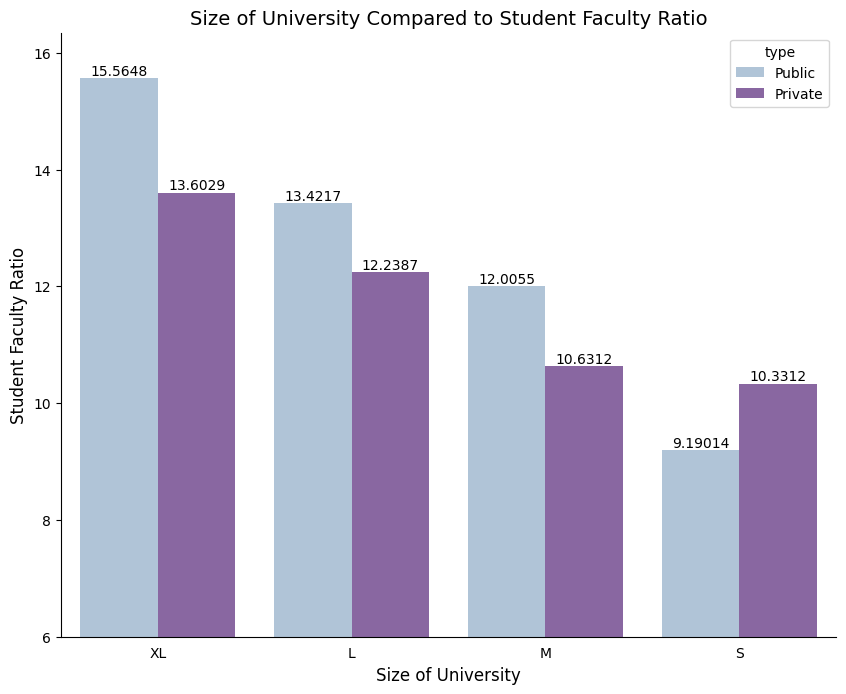

In [229]:
size_df = df.sort_values(['size'], ascending=False).reset_index(drop=True)
order= ['XL', 'L', 'M', 'S'] 
fig, ax = plt.subplots(figsize= (10,8), dpi=100)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(bottom=False)

sns.barplot(data = size_df,  x='size', y='student_faculty_ratio', 
            hue='type', order = order, 
            palette= pal, ci=None)

for container in ax.containers:
    ax.bar_label(container)

ax.set(ylim=(6, None))
plt.xlabel('Size of University', fontsize=12)
plt.ylabel('Student Faculty Ratio',fontsize = 12)
plt.title('Size of University Compared to Student Faculty Ratio', fontsize = 14)

Text(0.5, 1.0, 'Number of Public and Private Universities Ranked each Year')

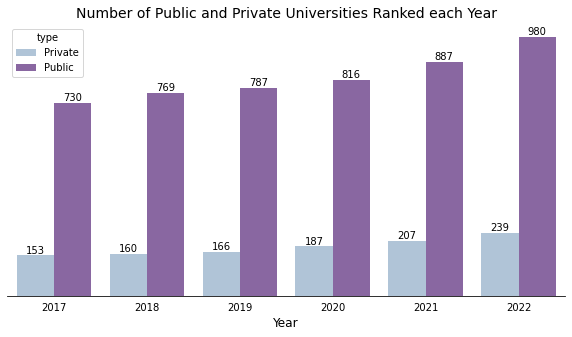

In [233]:
fig, ax = plt.subplots(figsize=(10,5))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(bottom=False)
ax.get_yaxis().set_visible(False)

sns.countplot(data=df, x='year', hue = 'type', palette=pal)

# add values on top of each bar
for container in ax.containers:
    ax.bar_label(container)

ax.set_xlabel('Year', fontsize=12)
ax.set_title('Number of Public and Private Universities Ranked each Year', fontsize=14)

#### Ranked Universities Across the World

Text(0.5, 0.98, 'Number of Universities by Continents')

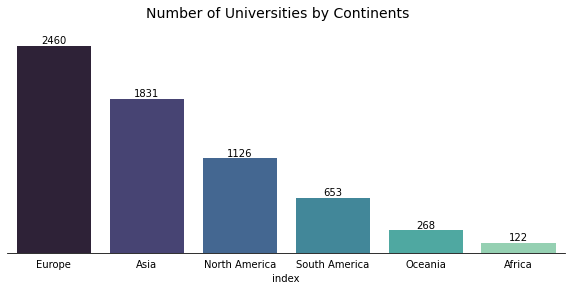

In [49]:
region_sum = pd.DataFrame(df['region'].value_counts().reset_index())

#fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), dpi=150, gridspec_kw={'height_ratios': [1, 2]})
fig, ax1 = plt.subplots(figsize=(10,4))

sns.barplot(data=region_sum, x='index', y = 'region', palette=pal)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.tick_params(bottom=False)
ax1.get_yaxis().set_visible(False)
ax1.bar_label(ax1.containers[0])



fig.suptitle('Number of Universities by Continents', fontsize=14)

Europe is home to the most ranked universities followed by Asia and North America.

#### Ranked Universities by Country

Text(0.5, 1.0, 'Ranked Universities by Country')

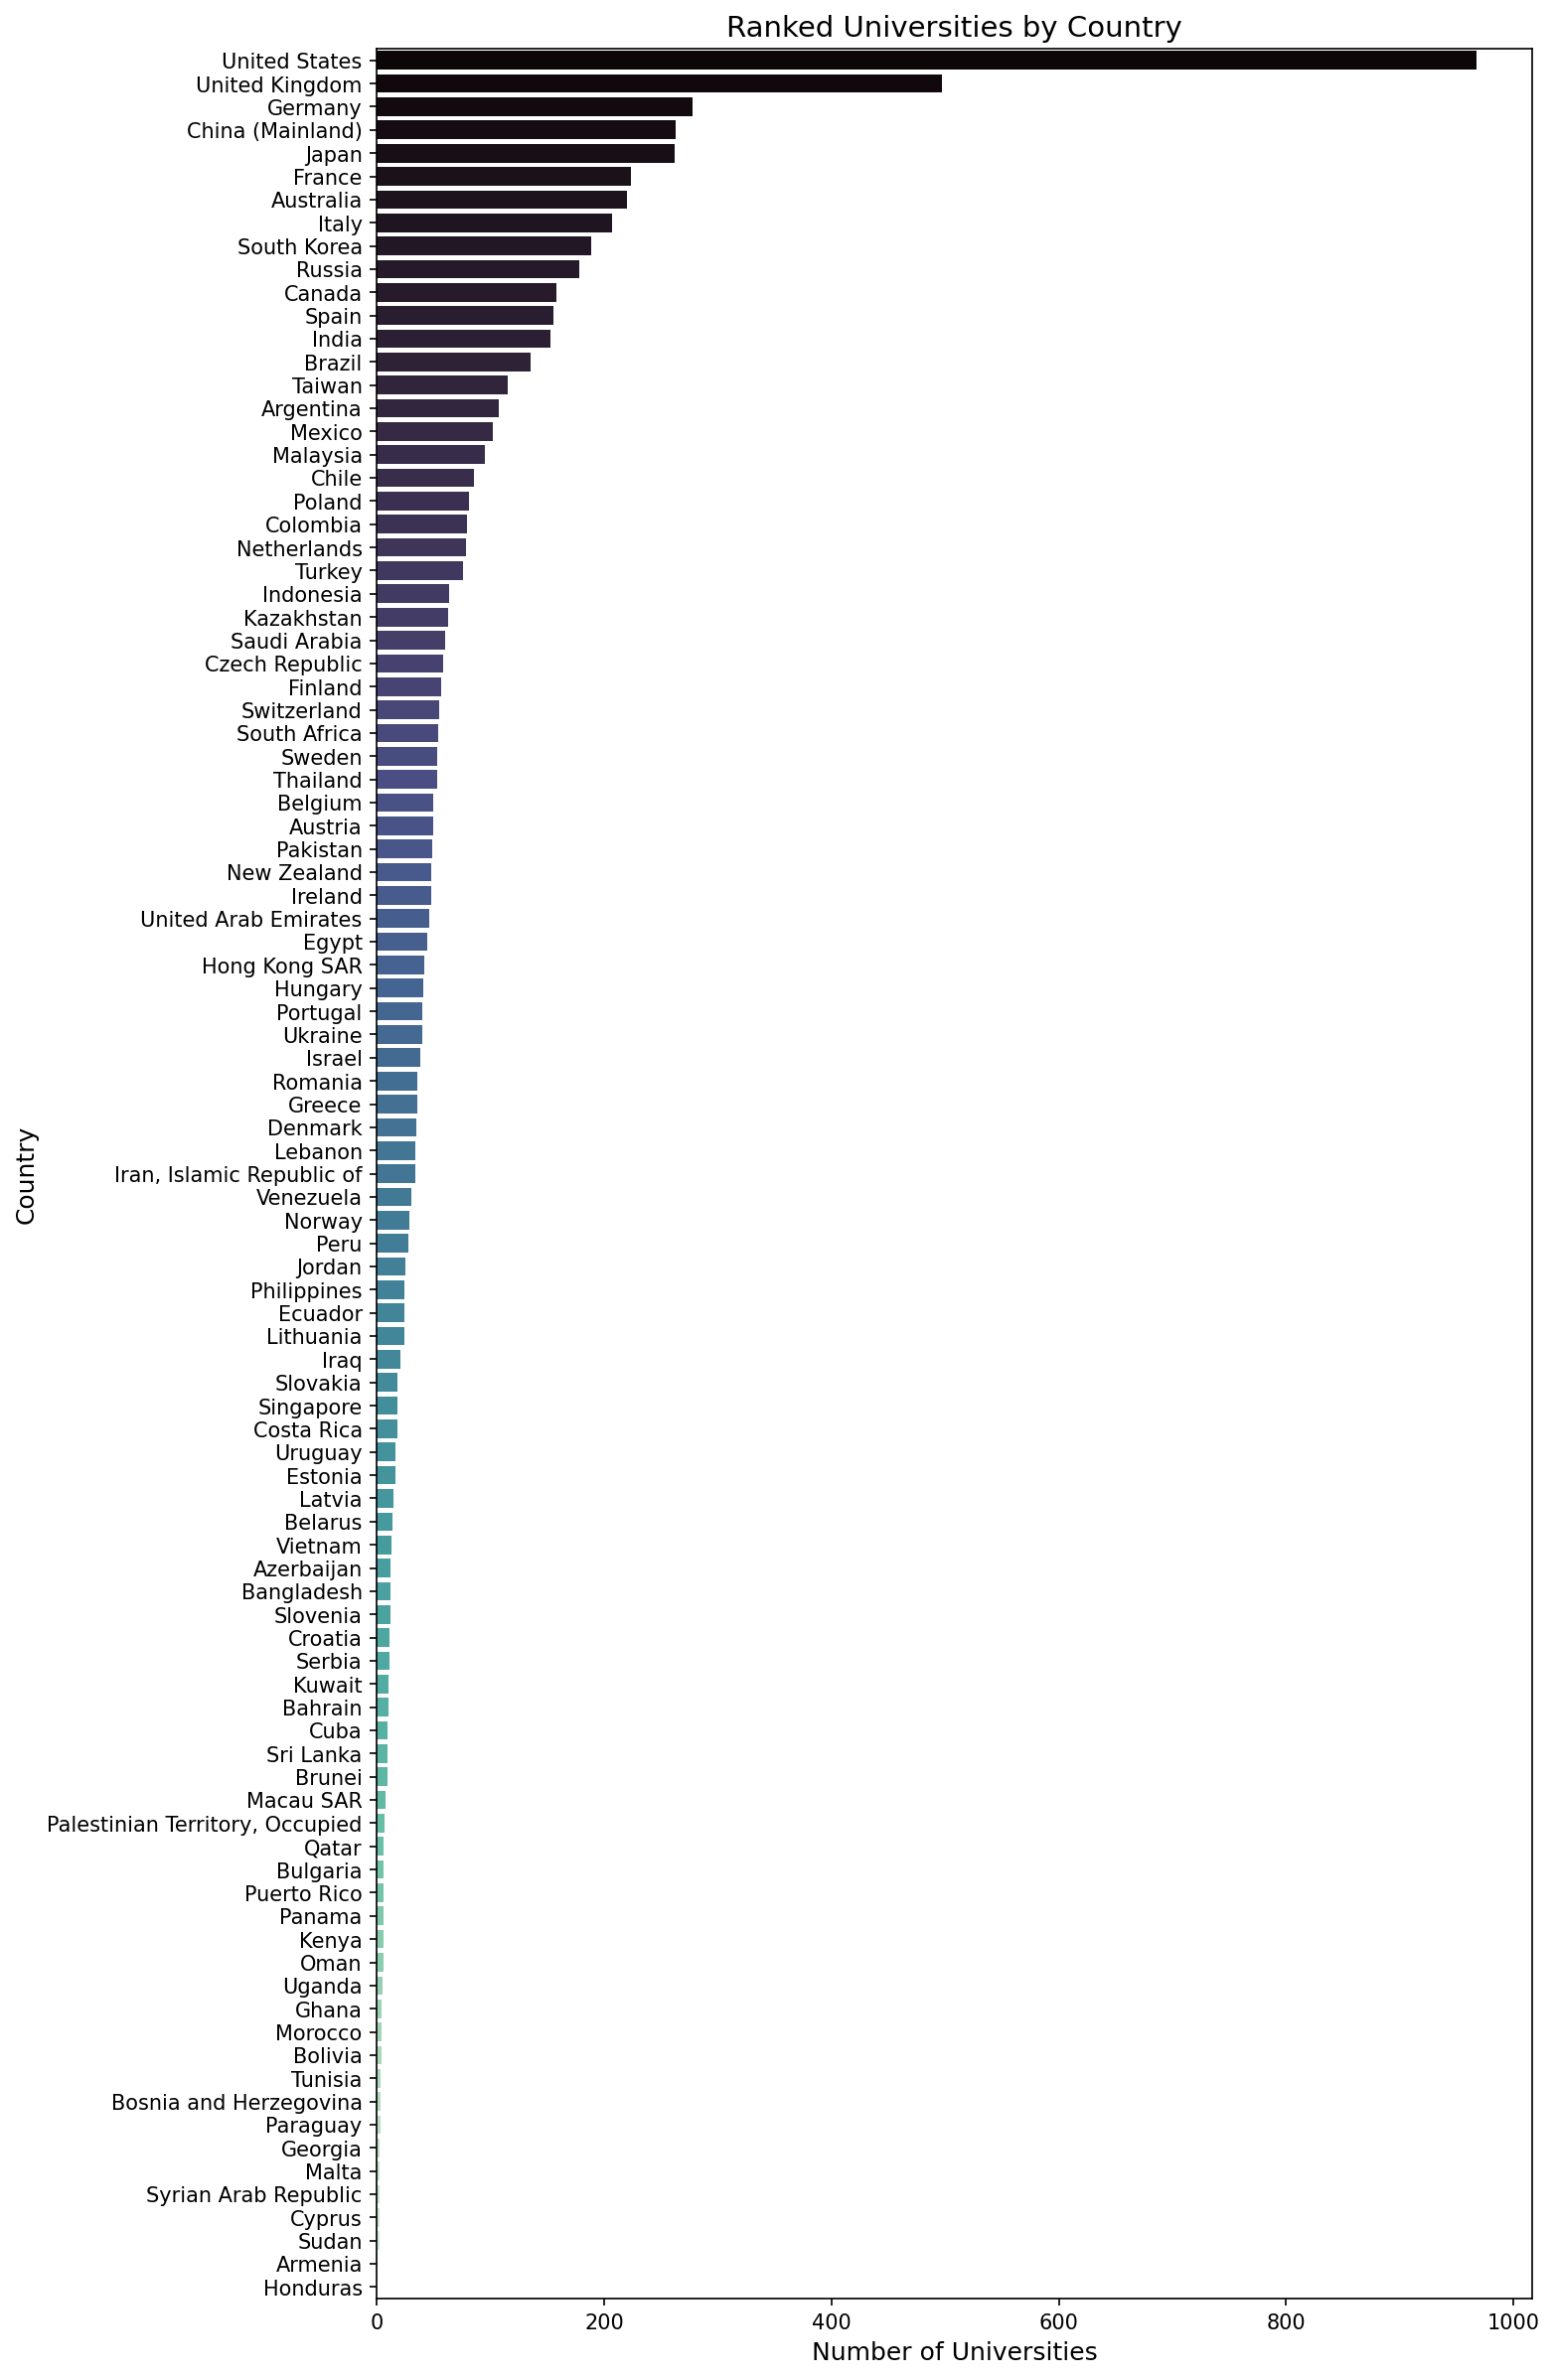

In [53]:
#uni_df = df['university'].value_counts()

fig, ax = plt.subplots(figsize=(10,20), dpi=150)

sns.countplot(data=df, y='country', order=df.country.value_counts().index, palette=pal)
plt.xlabel('Number of Universities', fontsize=12)
plt.ylabel('Country', fontsize = 12)
plt.title('Ranked Universities by Country', fontsize=14)



The United States leads followed by the United Kindgom and Germany.

#### Ranked Universities by City

In [54]:
sorted_df = df.sort_values(by='rank_display').drop_duplicates('university')
sorted_df = pd.DataFrame(sorted_df['city'].value_counts()[:20])

Text(0.5, 0.98, 'Number of Univerisities by City')

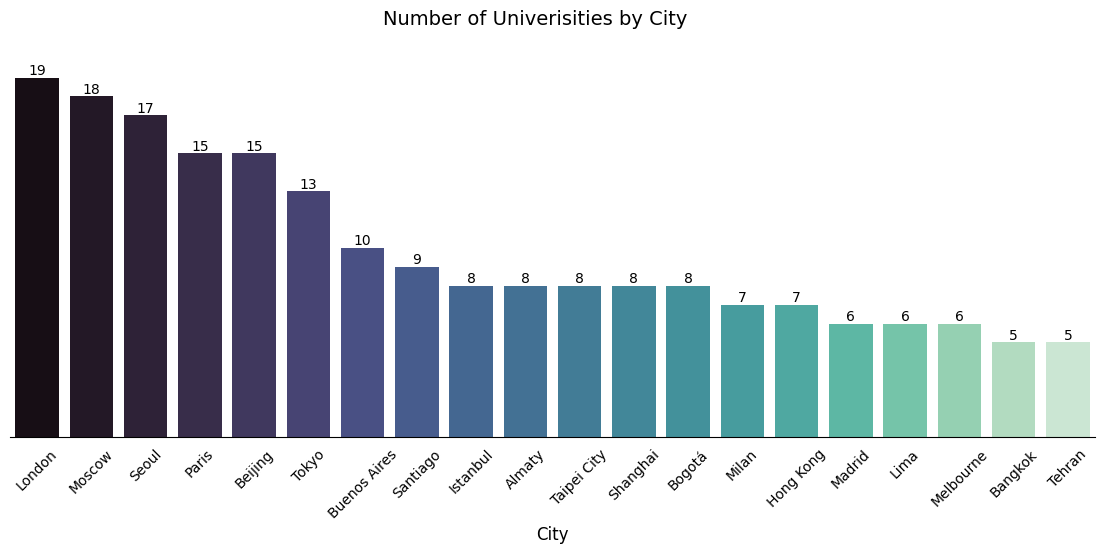

In [56]:
fig, ax = plt.subplots(figsize=(14,5), dpi=100)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(bottom=False)
ax.get_yaxis().set_visible(False)

sns.barplot(data=sorted_df, y='city', x=sorted_df.index, palette=pal)
plt.xticks(rotation=45)

ax.bar_label(ax.containers[0])

ax.set_xlabel('City', fontsize=12)
fig.suptitle('Number of Univerisities by City', fontsize=14)

London has 19 ranked universities followed by Moscow(18) as a close second. Rounding out the top three is Seoul with 17 universities.

#### Top Universities

Looking at the top universities each year

In [85]:
top_2022 = df.loc[df['year']== 2022]
top_2022 = top_2022.sort_values(by=['rank_display', 'university'])
top_2022 = top_2022.head(10)
uni_22 = top_2022['university'].to_list()

In [100]:
top = df.sort_values(by=['rank_display', 'university', 'year'])
uni_top = top.groupby(['university', 'rank_display']).size().reset_index().rename(columns={0:'count'}).sort_values(by = ['rank_display'])
uni_top

,university,rank_display,count
1550,Massachusetts Institute of Technology (MIT),10.0,6
2361,Stanford University,20.0,5
4145,University of Oxford,20.0,1
2362,Stanford University,30.0,1
930,Harvard University,30.0,5
...,...,...,...
225,Baku State University,100112000.0,1
782,Florida Atlantic University - Boca Raton,100112000.0,1
219,Babes-Bolyai University,100112000.0,1
4205,University of Rijeka,100112000.0,1


In [58]:
# university_df.sort_values('rank_display')[:60]
top_unis = ['Massachusetts Institute of Technology (MIT) ', 'Stanford University', 'University of Oxford', 'Harvard University', 'University of Cambridge', 'California Institute of Technology (Caltech)', 'ETH Zurich - Swiss Federal Institute of Technology', 'Imperial College London', 'UCL', 'University of Chicago']
topunis_df = df[df['university'].isin(top_unis)][['year','university','rank_display']].reset_index(drop=True)

fig = plt.figure(figsize=(15,15), dpi=100)

# for uni, i in zip(top_unis, range(1, 11)):
#     new_df = topunis_df[topunis_df['university'] == uni]
#     ax = fig.add_subplot(5, 2, i)
#     ax.plot(new_df['year'], new_df['rank_display'], color='#003f5c', linewidth=1.5)
#     plt.gca().invert_yaxis()
#     ax.set_title(uni, color='#ff4800')
    
# fig.subplots_adjust(wspace=0.2, hspace=0.6, top=0.92)
# fig.suptitle('Ranking of top 10 universities from 2017 to 2022', fontsize=15, color = '#ff4800')


<Figure size 1500x1500 with 0 Axes>

#### Methodology: Factors that Infulence Rankings

**Methodology**

QS designed its rankings to assess performance according to what it believes to be key aspects of a university's mission: teaching, research, nurturing employability, and internationalisation. The methodological framework it follows assess universities based on six metrics. <br>

Academic Reputation (40%)

Employer Reputation (10%)

Faculty/Student Ratio (20%)

Citations per faculty (20%)

International Faculty Ratio (5%)

International Student Ratio (5%)


**Citations per Faculty** 
Research (citations) output accounts for 20% of the overall rankings. 

Text(0.5, 0.98, 'Research Output per Faculty Count by University Type (Private or Public)')

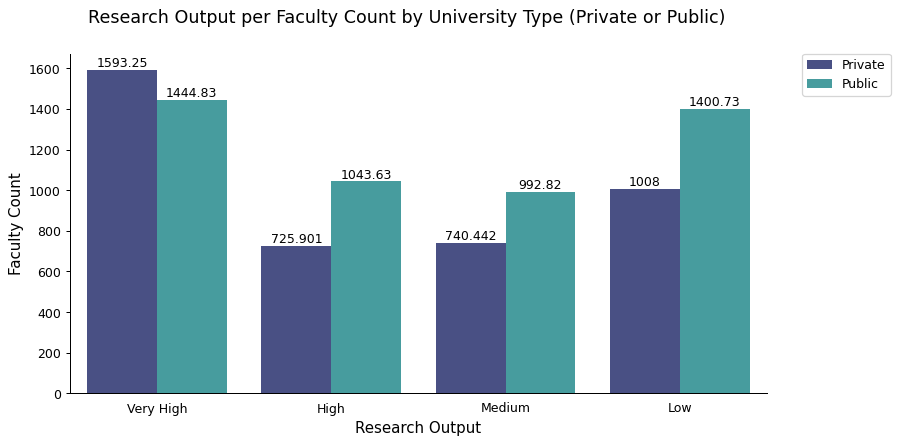

In [120]:
fig, ax = plt.subplots(figsize=(10,5), dpi=90)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(bottom=False)

sns.barplot(data=df, x='research_output', y='faculty_count', 
            hue='type', ci=None, palette=pal)

for container in ax.containers:
    ax.bar_label(container)

ax.set_xlabel('Research Output', fontsize=12)
ax.set_ylabel('Faculty Count', fontsize=12)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.suptitle('Research Output per Faculty Count by University Type (Private or Public)', fontsize=14)


It makes sense that universities with a larger number of faculty would have a higher level of research output. Interestingly, faculty count for both private and public university doesn't change much with the high and medium research levels. 

Public universities with a low research output have almost identical numbers of faculty members. This might be due to university funding. A university with low funding might make staffing a priority over research. However, a university with more funding is able to give research grants to its faculty members. 

Similarily, a private universtiy with more funding is able to spend more on research facilities and faculty members with a research background.

Text(0.5, 1.0, 'Research Output Compared to University Size')

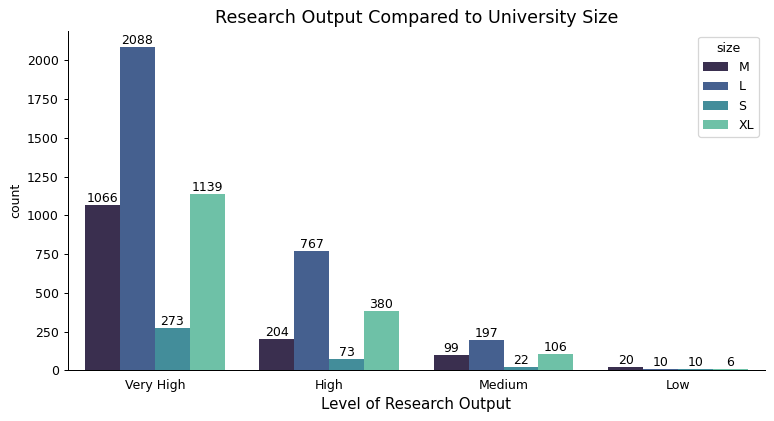

In [125]:
fig, ax = plt.subplots(figsize=(10,5), dpi=90)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(bottom=False)

sns.countplot(data=df, x='research_output', hue='size', palette=pal)

for container in ax.containers:
    ax.bar_label(container)

plt.xlabel('Level of Research Output', fontsize=12)
plt.title('Research Output Compared to University Size', fontsize=14)

The above graph makes sense as the larger the university, the more likely the level of research output is high. 

**Faculty to Student Ratio** 
The ratio of the number of faculty to the number of students makes up 20% of the overall rankings. 

Text(0.5, 1.0, 'Size of University Compared to Student Faculty Ratio')

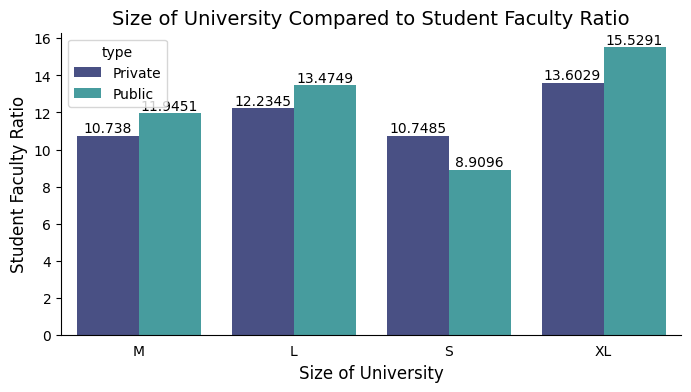

In [135]:
fig, ax = plt.subplots(figsize=(8,4), dpi=100)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(bottom=False)

sns.barplot(data=df, y='student_faculty_ratio', x='size', hue='type', palette= pal, ci=None)

for container in ax.containers:
    ax.bar_label(container)
    
plt.xlabel('Size of University', fontsize=12)
plt.ylabel('Student Faculty Ratio',fontsize = 12)
plt.title('Size of University Compared to Student Faculty Ratio', fontsize = 14)

**International Student to Faculty Ratio** 
The international student to faculty ratio makes up 10% of the rankings 

Text(0.5, 1.0, 'Distribution of International Students')

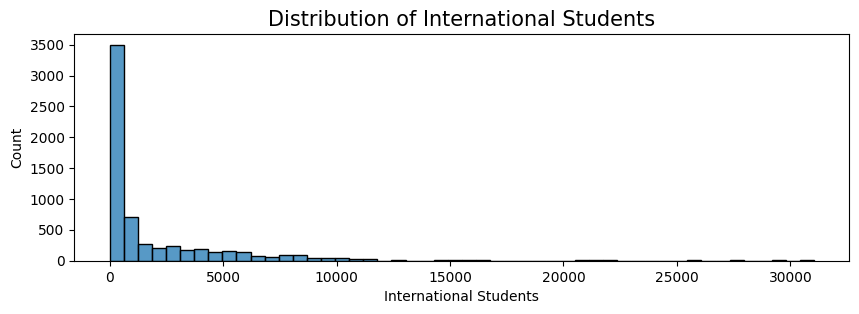

In [136]:
plt.figure(figsize=(10,3), dpi=100)
sns.histplot(data=df, x='international_students', bins=50, palette = pal)
plt.xlabel('International Students')
plt.ylabel('Count')
plt.title('Distribution of International Students', fontsize=15)

Text(0.5, 1.0, 'International Students Vs Research Output')

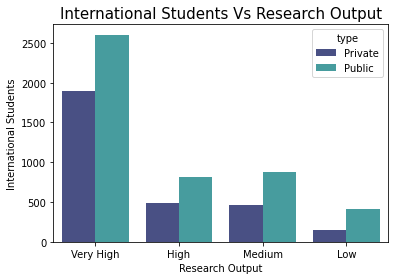

In [137]:
sns.barplot(data=df, x='research_output', y='international_students', 
            order=df['research_output'].value_counts().index, ci=None, hue='type',
            palette=pal)

plt.xlabel('Research Output')
plt.ylabel('International Students')
plt.title('International Students Vs Research Output', fontsize=15)

Text(0.5, 1.0, 'International Students Vs Research Output')

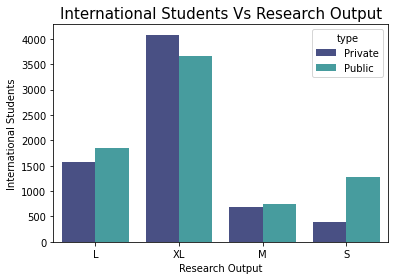

In [139]:
sns.barplot(data=df, x='size', y='international_students', 
            order=df['size'].value_counts().index, ci=None, hue='type',
            palette=pal)

plt.xlabel('Research Output')
plt.ylabel('International Students')
plt.title('International Students Vs Research Output', fontsize=15)

In [140]:
intstu_country = pd.DataFrame(df.groupby(['country'], sort=False)['international_students'].sum().sort_values(ascending=False)[:10])

Text(0.5, 0.98, 'Country of choice for International Students from 2017 - 2022')

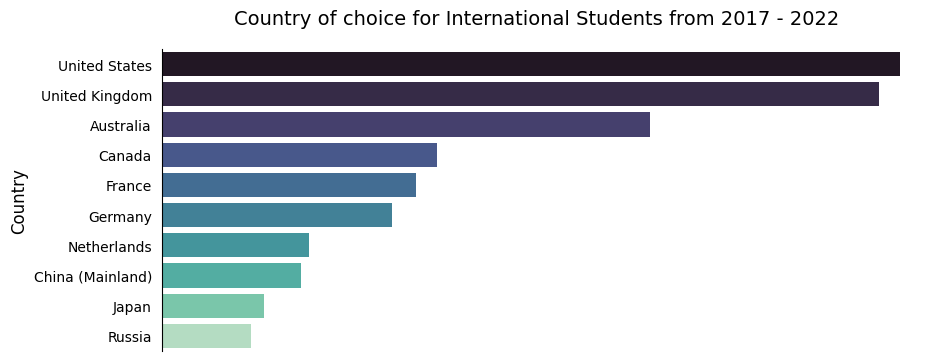

In [143]:
fig, ax = plt.subplots(figsize=(10,4), dpi=100)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(left=False)
ax.get_xaxis().set_visible(False)

sns.barplot(data=intstu_country, x='international_students', y=intstu_country.index, palette=pal)

#ax.bar_label(ax.containers[0], fmt = '%d')

ax.set_ylabel('Country', fontsize=12)
fig.suptitle('Country of choice for International Students from 2017 - 2022', fontsize=14)

In [144]:
df.head()

,university,year,rank_display,country,city,region,type,research_output,student_faculty_ratio,international_students,size,faculty_count
0,Massachusetts Institute of Technology (MIT),2017,10.0,United States,Cambridge,North America,Private,Very High,4.0,3730.0,M,3065.0
1,Stanford University,2017,20.0,United States,Stanford,North America,Private,Very High,3.0,3879.0,L,4725.0
2,Harvard University,2017,30.0,United States,Cambridge,North America,Private,Very High,5.0,5877.0,L,4646.0
3,University of Cambridge,2017,40.0,United Kingdom,Cambridge,Europe,Public,Very High,4.0,7925.0,L,5800.0
4,California Institute of Technology (Caltech),2017,50.0,United States,Pasadena,North America,Private,Very High,2.0,692.0,S,968.0
